In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mglearn
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder, StandardScaler
from scipy.stats import normaltest, probplot, poisson, chisquare, shapiro, ttest_ind, chi2_contingency
import scipy
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
plt.rc("font", family="Verdana") # кириллица
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import log_loss

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mglearn
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder, StandardScaler
from scipy.stats import normaltest, probplot, poisson, chisquare, shapiro, ttest_ind, chi2_contingency
import scipy
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
plt.rc("font", family="Verdana") # кириллица
from sklearn.feature_selection import f_classif
%matplotlib inline
plt.rcParams['image.cmap'] = "gray"

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [227]:
table_Pasha = pd.read_excel("./datasets/Разметка паша.xlsx")
table_Max = pd.read_excel("./datasets/Разметка макс.xlsx")
table_Pasha.columns = table_Max.columns = ["Дата", "Дата_получения_локации", "Широта", 
                                           "Долгота", "Высота", "Скорость", "Точность", "Ax", 
                                           "Ay", "Az", "Сердечный_Ритм", "Шаги", "Разметка"]
print("Измененные колонки для \nПервого датасета {}, \nВторого датасета {}".format(list(table_Pasha.columns), 
                                                                                   list(table_Max.columns)))

Измененные колонки для 
Первого датасета ['Дата', 'Дата_получения_локации', 'Широта', 'Долгота', 'Высота', 'Скорость', 'Точность', 'Ax', 'Ay', 'Az', 'Сердечный_Ритм', 'Шаги', 'Разметка'], 
Второго датасета ['Дата', 'Дата_получения_локации', 'Широта', 'Долгота', 'Высота', 'Скорость', 'Точность', 'Ax', 'Ay', 'Az', 'Сердечный_Ритм', 'Шаги', 'Разметка']


In [3]:
def ens_model(X, y, enc, X_valid, y_valid, model=RandomForestClassifier, **params): # Построение модели и некоторые дополнительные возможности
    
    """X - по каким данным нужно предсказать, y - что конкретно предсказать, 
       enc - кодировщик классов цифрами, X_valid, y_valid - валидационный набор данных, 
       model - выбранная модель ml (Случайный лес по умолчанию), params - параметры, передаваемые модели"""
    
    if model == RandomForestClassifier: # Вычисление oob_score
        params = {"oob_score": True} 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y) # Разбиение данных на обучающие и тестовые
    forest = model(n_jobs=-1, random_state=1, **params).fit(X_train, y_train) # Обучение модели, фиксируем random_state для репрезентативности
    print("Правильность на тестовом наборе: {:.2f}".format(forest.score(X_test, y_test)))
    if model == RandomForestClassifier: # Вывод точности на oob выборке
        print("oob score: ", forest.oob_score_)
    print(classification_report(forest.predict(X_test), y_test))
    score_image = mglearn.tools.heatmap(
                        confusion_matrix(y_test, forest.predict(X_test)),
                        xlabel="Спрогнозировання метка класса",
                        ylabel="Фактическая метка класса",
                        xticklabels=sorted(enc.classes_[y_test.unique()]),
                        yticklabels=sorted(enc.classes_[y_test.unique()]),
                        cmap=plt.cm.gray_r, fmt="%d") # Confusion matrix
    
    if not X_valid.empty and not y_valid.empty: # Применяем валидационный набор для финальной проверки правильности
        print("Правильность на валидационном наборе: {:.2f}".format(forest.score(X_valid, y_valid)))
        print("Конфьюжион матрикс и отчет по валидационному набору:\n")
        print(classification_report(forest.predict(X_valid), y_valid))
        plt.figure()
        score_image = mglearn.tools.heatmap(
                        confusion_matrix(y_valid, forest.predict(X_valid)),
                        xlabel="Спрогнозировання метка класса",
                        ylabel="Фактическая метка класса",
                        xticklabels=sorted(enc.classes_[y_valid.Разметка.unique()]),
                        yticklabels=sorted(enc.classes_[y_valid.Разметка.unique()]),
                        cmap=plt.cm.gray_r, fmt="%d")
    return forest # Возвращаем из функции созданную модель

def predict(X, test_data=pd.Series([], dtype="object")): # Разметка классов и удаление даты из данных для модели
    
    """X - входные данные (включая классы), test_data - валидационный набора данных"""
    
    X_valid, y_valid = pd.Series([], dtype="object"), pd.Series([], dtype="object")
    def check(X): # проверка признаков на столбцы о дате и удаление в случае их обнаружения
        if "Дата" in X.columns and "Дата_получения_локации" in X.columns:
            X = X.drop(["Дата", "Дата_получения_локации"], axis=1)
        elif "Дата" in X.columns:
            X = X.drop(["Дата"], axis=1)
        elif "Дата_получения_локации" in X.columns:
            X = X.drop(["Дата_получения_локации"], axis=1)
        return X
    
    y_enc = ['a', 'b', 'd', 'c', 'e'] # "Алфавит кодирования"
    enc = LabelEncoder() # Экземпляр кодировщика
    enc.fit(y_enc) # Обучение
    y_P = pd.DataFrame(enc.transform(X["Разметка"]), columns=["Разметка"]) # Трансформация разметки
    X_P = X.drop(["Разметка"], axis=1)
    X_P = check(X_P)
    if not test_data.empty:
        y_valid = pd.DataFrame(enc.transform(test_data["Разметка"]), columns=["Разметка"])
        X_valid = check(test_data.drop(["Разметка"], axis=1))
    forest = ens_model(X_P, y_P.Разметка, enc, X_valid, y_valid) # Ловим возвращаемую модель из вызываемой функции
    return forest # Возвращаем модель и выходим основое тело программы



def agg_interval(df, column="Дата", sample_time="3S"):
    
    """Принимает на вход датафрейм, название колонки в которой содержится информация о времени (по умолчанию дата),
       а также время за которое нужно агрегировать наблюдения (по умолчанию 3 секунды)"""
    
    V = ""
    def f(x):
        
        """Так как в pandas нет способа работать с категориальными переменными для 
           переиндексации по времени, то напишем эту функцию вручную, принимается на вход последовательность 
           категориальных признаков за определенный промежуток времени"""
        
        nonlocal V
        mode = str(*stats.mode(list(x)).mode) # вычисления моды
        if not mode: # в случае пустого множества (информации за этот промежуток нету) берется предыдущая мода
            mode = V
        else:
            V = mode
        return mode
    
    d = {'Разметка': f} # словарь с объектом пользовательской функции
    for x in set(df.columns) - set(["Разметка", column]): # для вещественных признаков записываем в словарь функцию mean по столбцам
        d[x] = np.mean # np.mean имеет сигнатуру как у agg_interval, только вычисляет среднее (мат ожидание), а не моду
    new_df =  df.set_index(column).resample(sample_time).agg(d) # агрегируем по входному времени sample_time и функциям для наших столбцов
    print("Количество пропущенных значений (столбец):", new_df.iloc[:, 3].isnull().values.sum()) # Выводим счетчик
    print("Всего значений (столбец):", new_df.shape[0])
    for i in new_df.columns: # итерируемся по столбцам
        new_df[i].fillna(method="ffill", inplace=True) # случае пустых значений (нету наблюдений за определенное время) берем предыдущее
    return new_df # возрващаем новый датафрейм



In [46]:
def change_class_inplace(df):
    df.replace({'Разметка': 'c'}, 'e', inplace=True)
    df.replace({'Разметка': 'd'}, 'c', inplace=True)
    df.replace({'Разметка': 'f'}, 'e', inplace=True)
    df.replace({'Разметка': 'g'}, 'd', inplace=True)
    df.replace({'Разметка': 'h'}, 'f', inplace=True)
    df.replace({'Разметка': 'i'}, 'd', inplace=True)
    df.replace({'Разметка': 'j'}, 'c', inplace=True)
    df.replace({'Разметка': 'k'}, 'a', inplace=True)
    loss = df.query('Разметка == "l"')
    df.drop(df[df.Разметка == "l"].index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return loss

pasha_loss = change_class_inplace(table_Pasha)
max_loss = change_class_inplace(table_Max)

In [26]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print("Данные первого датасета:\n{}\n\n\nДанные второго датасета\n{}"
          .format(table_Max.describe(), table_Pasha.describe()))

Данные первого датасета:
        Широта  Долгота   Высота  Скорость  Точность            Ax  \
count  98836.0  98836.0  98836.0   98836.0   98836.0  98836.000000   
mean       0.0      0.0      0.0       0.0       0.0      5.708649   
std        0.0      0.0      0.0       0.0       0.0      5.028641   
min        0.0      0.0      0.0       0.0       0.0    -29.400999   
25%        0.0      0.0      0.0       0.0       0.0      2.049000   
50%        0.0      0.0      0.0       0.0       0.0      6.148000   
75%        0.0      0.0      0.0       0.0       0.0      9.807000   
max        0.0      0.0      0.0       0.0       0.0     39.208000   

                 Ay            Az  Сердечный_Ритм          Шаги  
count  98836.000000  98836.000000    98836.000000  98836.000000  
mean      -4.455635      0.263577       69.864163   1033.377271  
std        4.227270      4.912282        9.283915    726.247543  
min      -39.228001    -39.208000        0.000000      0.000000  
25%       -7.6

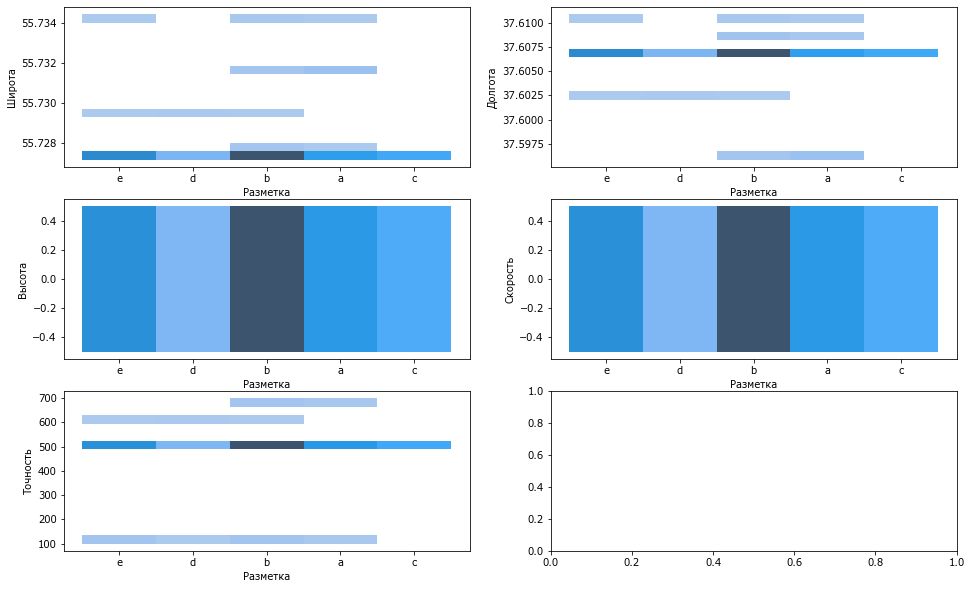

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))
features = ["Широта", "Долгота", "Высота", "Скорость", "Точность"]
for idx, feat in enumerate(features):
    sns.histplot(y=feat, x="Разметка", data=table_Pasha, ax=axes[idx // 2, idx % 2])

In [83]:
table_Pasha.Разметка.unique()

array(['e', 'd', 'b', 'a', 'c'], dtype=object)

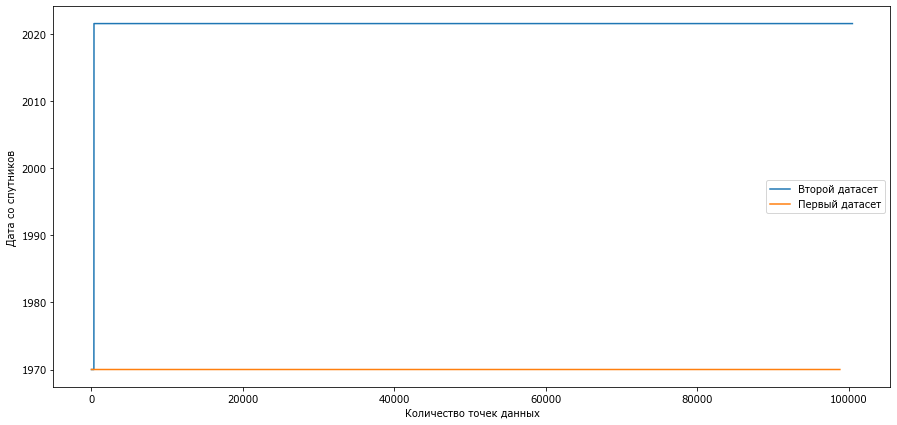

In [230]:
plt.figure(figsize=(15, 7))
table_Pasha.Дата_получения_локации.plot(label="Второй датасет")
table_Max.Дата_получения_локации.plot(label="Первый датасет")
plt.legend();
plt.xlabel("Количество точек данных")
plt.ylabel("Дата со спутников");

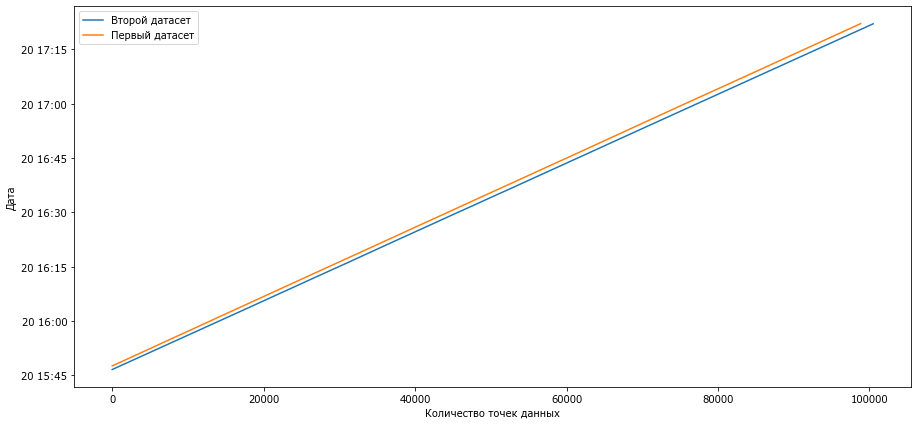

In [228]:
plt.figure(figsize=(15, 7))
table_Pasha.Дата.plot(label="Второй датасет")
table_Max.Дата.plot(label="Первый датасет")
plt.legend();
plt.xlabel("Количество точек данных")
plt.ylabel("Дата");

In [47]:
table_Pasha.drop(axis=1, inplace=True, columns=["Широта", "Долгота", "Дата", "Высота", "Скорость", 
                                                "Точность", 'Дата_получения_локации'])
table_Max.drop(axis=1, inplace=True, columns=["Широта", "Долгота", "Дата", "Высота", "Скорость", 
                                              "Точность", 'Дата_получения_локации'])

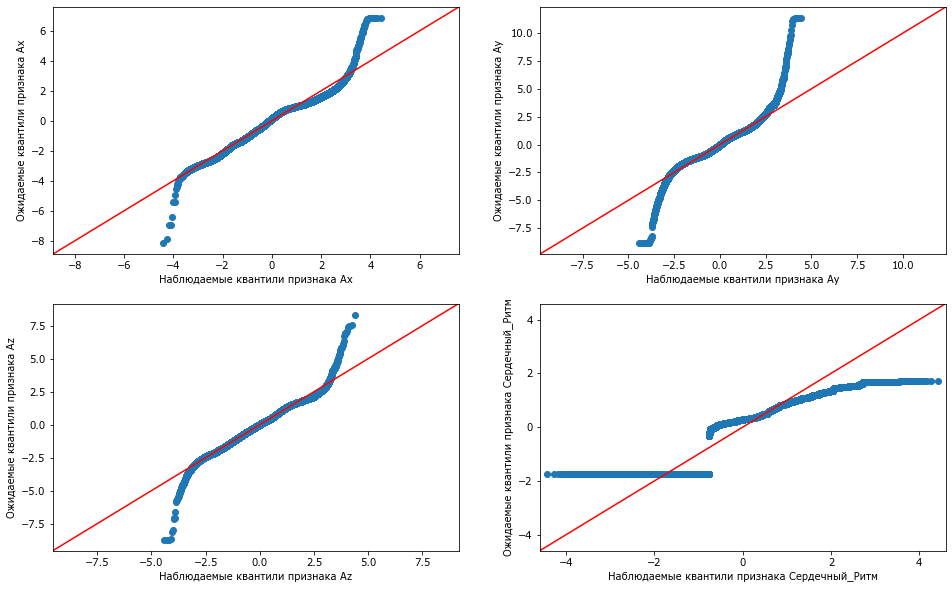

In [44]:
corr_table = pd.concat([table_Pasha.drop(["Разметка", "Шаги"], axis=1), table_Max.drop(["Разметка", "Шаги"], axis=1)], axis=0)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
for idx, x in enumerate(corr_table):
    pp = sm.ProbPlot(corr_table[x].values, fit=True);
    pp.qqplot(line="45", ax=axes[idx // 2, idx % 2])
    axes[idx // 2, idx % 2].set_xlabel("Наблюдаемые квантили признака {}".format(x))
    axes[idx // 2, idx % 2].set_ylabel("Ожидаемые квантили признака {}".format(x))

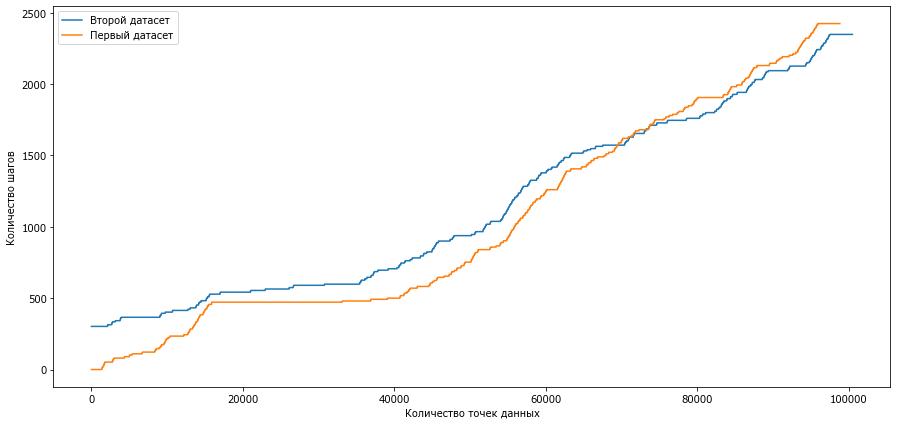

In [80]:
plt.figure(figsize=(15, 7))
table_Pasha.Шаги.plot(label="Второй датасет")
table_Max.Шаги.plot(label="Первый датасет")
plt.legend();
plt.xlabel("Количество точек данных")
plt.ylabel("Количество шагов");

Правим Шаги


In [48]:
table_Pasha_new = table_Pasha.copy()
table_Max_new = table_Max.copy()

In [49]:
p_f_u = [int(x) for x in table_Pasha.Шаги.unique()]
m_f_u = [int(x) for x in table_Max.Шаги.unique()]

In [50]:
def foot(c, f_u):
    c = int(c)
    if c != f_u[0]:
        return c - f_u[f_u.index(c) - 1]
    else:
        return f_u[0]

In [51]:
table_Pasha_new["Шаги"] = table_Pasha.Шаги.apply(foot, args=(p_f_u,))
table_Max_new["Шаги"] = table_Max.Шаги.apply(foot, args=(m_f_u,))

In [52]:
table_Pasha_new.replace({"Шаги": 502}, 2, inplace=True)

In [54]:
scaled_features = StandardScaler().fit_transform(table_Pasha_new.drop(["Разметка"], axis=1))
table_Pasha_new_s = pd.concat([pd.DataFrame(scaled_features, 
                                            columns=table_Pasha_new.drop(["Разметка"], axis=1).columns), 
                               table_Pasha_new[["Разметка"]]], axis = 1)

scaled_features = StandardScaler().fit_transform(table_Max_new.drop(["Разметка"], axis=1))
table_Max_new_s = pd.concat([pd.DataFrame(scaled_features, 
                                          columns=table_Max_new.drop(["Разметка"], axis=1).columns), 
                             table_Max_new[["Разметка"]]], axis = 1) 

In [232]:
def agg_interval(df, sample_time="5S"):
    def mode_int(x):
        return stats.mode(x).mode
    
    def quantile_25(x):
        return np.quantile(x, .25)
    
    def quantile_75(x):
        return np.quantile(x, .75)
    
    def str_func(x):
        if len(x) <= 1:
            return "0" + x
        else:
            return x
    
    V = ""
    def mode_str(x):
        nonlocal V
        mode = str(*stats.mode(list(x)).mode)
        if not mode:
            mode = V
        else:
            V = mode
        return mode
    
    indexx = df.reset_index().index
    hours = indexx // 3600
    minutes = indexx // 60 - (indexx // 3600) * 60
    seconds = indexx - hours * 3600 - minutes * 60
    
    hms = pd.DataFrame({'hour': hours,
                   'minute': minutes,
                   'second': seconds})
    
    df = pd.concat([pd.DataFrame(pd.to_datetime(hms.iloc[:, 0].astype(str).apply(str_func) \
                                           + ":" + hms.iloc[:, 1].astype(str).apply(str_func) \
                                           + ":" + hms.iloc[:, 2].astype(str)\
               .apply(str_func), format="%H:%M:%S"), columns=["Date"]), df], axis=1)
    
    d = {'Разметка': mode_str}
    for x in set(df.columns) - set(["Разметка", "Date"]): 
        d[x] = [mode_int, quantile_25, quantile_75, np.mean, np.std, stats.skew, stats.kurtosis, \
                np.min, np.max, stats.entropy]
    new_df =  df.set_index("Date").resample(sample_time).agg(d)
    print("Количество пропущенных значений (столбец):", new_df.iloc[:, 3].isnull().values.sum())
    print("Всего значений (столбец):", new_df.shape[0])
    for i in new_df.columns: # итерируемся по столбцам
        new_df[i].fillna(method="ffill", inplace=True)
        
    return new_df

table_Pasha_new_s_feature = agg_interval(table_Pasha_new_s)
table_Max_new_s_feature = agg_interval(table_Max_new_s)

Количество пропущенных значений (столбец): 0
Всего значений (столбец): 11121
Количество пропущенных значений (столбец): 0
Всего значений (столбец): 10685


In [233]:
table_s_feature = pd.concat([table_Pasha_new_s_feature, table_Max_new_s_feature], axis=0)

In [252]:
table_s_feature.to_csv('table_s_feature1.csv', index=False)

In [310]:
table_s_feature = pd.read_csv('table_s_feature1.csv')

In [156]:
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import log_loss

In [235]:
table_s_feature = table_s_feature.reset_index(drop=True)

In [236]:
X_train, X_test, y_train, y_test = train_test_split(clean_dataset(table_s_feature.drop("Разметка", axis=1)), 
                                                    table_s_feature["Разметка"], 
                                                    random_state=1, test_size=.15)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=.18)

Правильность на валидационном наборе: 0.72
              precision    recall  f1-score   support

           0       0.63      0.84      0.72       503
           1       0.86      0.66      0.75      1488
           2       0.57      0.68      0.62       299
           3       0.48      0.83      0.61       134
           4       0.72      0.74      0.73       913

    accuracy                           0.72      3337
   macro avg       0.65      0.75      0.69      3337
weighted avg       0.75      0.72      0.72      3337



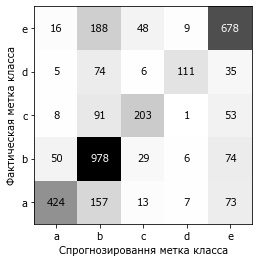

In [237]:
y_enc = ['a', 'b', 'd', 'c', 'e']
enc = LabelEncoder()
enc.fit(y_enc)
y_train_rf = pd.DataFrame(enc.transform(y_train.values.ravel()), columns=["Разметка"])
y_valid_rf = pd.DataFrame(enc.transform(y_valid.values.ravel()), columns=["Разметка"])

forest = RandomForestClassifier(n_jobs=-1, random_state=1, n_estimators=500).fit(X_train, y_train_rf.values.ravel())

print("Правильность на валидационном наборе: {:.2f}".format(forest.score(X_valid, y_valid_rf.values.ravel())))
print(classification_report(forest.predict(X_valid), y_valid_rf))
score_image = mglearn.tools.heatmap(
                        confusion_matrix(y_valid_rf, forest.predict(X_valid)),
                        xlabel="Спрогнозировання метка класса",
                        ylabel="Фактическая метка класса",
                        xticklabels=sorted(enc.classes_[sorted(y_valid_rf["Разметка"].unique())]),
                        yticklabels=sorted(enc.classes_[sorted(y_valid_rf["Разметка"].unique())]),
                        cmap=plt.cm.gray_r, fmt="%d")

In [245]:
d = {}
for i in zip(X_valid.columns, forest.feature_importances_):
    d[i[0]] = i[1]
d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
i1 = 0
for i in d:
    i1 += 1
    print("Важность признака: {} для распознавания составляет: {}".format(i, d[i]))
    if i1 == 10:
        break

Важность признака: ('Сердечный_Ритм', 'amax') для распознавания составляет: 0.04086876164779832
Важность признака: ('Сердечный_Ритм', 'quantile_25') для распознавания составляет: 0.040085241853112984
Важность признака: ('Сердечный_Ритм', 'amin') для распознавания составляет: 0.03993670154615873
Важность признака: ('Сердечный_Ритм', 'mean') для распознавания составляет: 0.03920900479010118
Важность признака: ('Сердечный_Ритм', 'quantile_75') для распознавания составляет: 0.03888691089981775
Важность признака: ('Сердечный_Ритм', 'mode_int') для распознавания составляет: 0.03842620617688737
Важность признака: ('Ax', 'amax') для распознавания составляет: 0.026346881808633146
Важность признака: ('Ax', 'mean') для распознавания составляет: 0.0261099574596884
Важность признака: ('Ay', 'mean') для распознавания составляет: 0.026095774945780473
Важность признака: ('Ax', 'quantile_75') для распознавания составляет: 0.02562247974089227


In [239]:
model = cb.CatBoostClassifier(task_type="GPU")
model.fit(X_train,y_train, eval_set=(X_valid, y_valid), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Правильность на валидационном наборе: 0.66
              precision    recall  f1-score   support

           a       0.57      0.75      0.65       508
           b       0.79      0.61      0.69      1467
           c       0.49      0.61      0.54       289
           d       0.39      0.66      0.49       137
           e       0.68      0.68      0.68       936

    accuracy                           0.66      3337
   macro avg       0.58      0.66      0.61      3337
weighted avg       0.68      0.66      0.66      3337



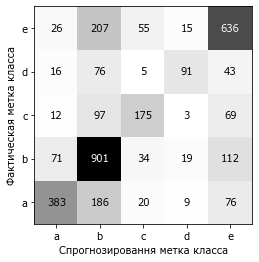

In [246]:
print("Правильность на валидационном наборе: {:.2f}".format(model.score(X_valid, y_valid)))
print(classification_report(model.predict(X_valid), y_valid))
plt.figure()
score_image = mglearn.tools.heatmap(
                        confusion_matrix(y_valid, model.predict(X_valid)),
                        xlabel="Спрогнозировання метка класса",
                        ylabel="Фактическая метка класса",
                        xticklabels=sorted(y_valid.mode_str.unique()),
                        yticklabels=sorted(y_valid.mode_str.unique()),
                        cmap=plt.cm.gray_r, fmt="%d")

In [247]:
test_pool = cb.Pool(X_valid, y_valid, feature_names=list(X_valid.columns))

In [248]:
d = {}
for i in zip(X_valid.columns, model.feature_importances_):
    d[i[0]] = i[1]
d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
i1 = 0
for i in d:
    i1 += 1
    print("Важность признака: {} для распознавания составляет: {}".format(i, d[i]))
    if i1 == 10:
        break

Важность признака: ('Сердечный_Ритм', 'amax') для распознавания составляет: 6.034646509272406
Важность признака: ('Сердечный_Ритм', 'amin') для распознавания составляет: 5.869710484940761
Важность признака: ('Сердечный_Ритм', 'mean') для распознавания составляет: 3.491512459233916
Важность признака: ('Сердечный_Ритм', 'quantile_75') для распознавания составляет: 3.3877146429451064
Важность признака: ('Шаги', 'amax') для распознавания составляет: 3.219201959119424
Важность признака: ('Ax', 'std') для распознавания составляет: 3.0108764150074827
Важность признака: ('Ay', 'quantile_75') для распознавания составляет: 2.961757460726812
Важность признака: ('Шаги', 'mean') для распознавания составляет: 2.9158146844534842
Важность признака: ('Az', 'std') для распознавания составляет: 2.8175818810422197
Важность признака: ('Ay', 'amax') для распознавания составляет: 2.776177783792413


Правильность на тестовом наборе: 0.72
              precision    recall  f1-score   support

           0       0.63      0.86      0.73       496
           1       0.87      0.66      0.75      1456
           2       0.56      0.69      0.62       304
           3       0.45      0.71      0.55       151
           4       0.72      0.73      0.73       864

    accuracy                           0.72      3271
   macro avg       0.65      0.73      0.67      3271
weighted avg       0.75      0.72      0.72      3271



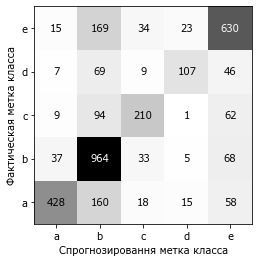

In [251]:
y_enc = ['a', 'b', 'd', 'c', 'e']
enc = LabelEncoder()
enc.fit(y_enc)
y_test_rf = pd.DataFrame(enc.transform(y_test.values.ravel()), columns=["Разметка"])

print("Правильность на тестовом наборе: {:.2f}".format(forest.score(X_test, y_test_rf.values.ravel())))
print(classification_report(forest.predict(X_test), y_test_rf.values.ravel()))
score_image = mglearn.tools.heatmap(
                        confusion_matrix(y_test_rf.values.ravel(), forest.predict(X_test)),
                        xlabel="Спрогнозировання метка класса",
                        ylabel="Фактическая метка класса",
                        xticklabels=sorted(enc.classes_[sorted(y_test_rf["Разметка"].unique())]),
                        yticklabels=sorted(enc.classes_[sorted(y_test_rf["Разметка"].unique())]),
                        cmap=plt.cm.gray_r, fmt="%d")

Декодирование меток классов:
a - простой, b - перемещение, 
c - низкая мобильная активность
d - высокая мобильная активность
e - низкая статическая активность,
f - высокая статическая активность
Метка - встречаемость:
b    1456
e     864
a     496
c     304
d     151
dtype: int64



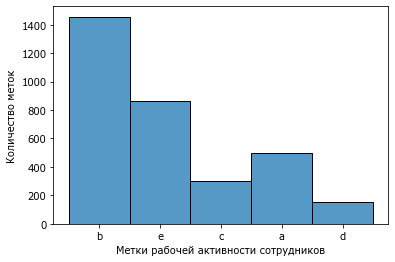

In [250]:
f_p = enc.inverse_transform(forest.predict(X_test))
print("Декодирование меток классов:\na - простой, b - перемещение, \nc - низкая мобильная активность" + 
      "\nd - высокая мобильная активность\ne - низкая статическая активность,\nf - высокая статическая активность")
print("Метка - встречаемость:\n{}\n".format(pd.value_counts(f_p)))
sns.histplot(f_p);
plt.xlabel("Метки рабочей активности сотрудников")
plt.ylabel("Количество меток");

In [ ]:
## Считывание изучаемых данных
table_Pasha = pd.read_excel("./datasets/Разметка паша.xlsx")
table_Max = pd.read_excel("./datasets/Разметка макс.xlsx")
table_Pasha.columns = table_Max.columns = ["Дата", "Дата_получения_локации", "Широта", 
                                           "Долгота", "Высота", "Скорость", "Точность", "Ax", 
                                           "Ay", "Az", "Сердечный_Ритм", "Шаги", "Разметка"]
print("Измененные колонки для \nПервого датасета {}, \nВторого датасета {}".format(list(table_Pasha.columns), 
                                                                                   list(table_Max.columns)))

## Статистические характеристики изучаемых данных
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print("Данные первого датасета:\n{}\n\n\nДанные второго датасета\n{}"
          .format(table_Max.describe(), table_Pasha.describe()))

## Распределение признака “Дата_получения_локации” в датасетах
plt.figure(figsize=(15, 7))
table_Pasha.Дата_получения_локации.plot(label="Второй датасет")
table_Max.Дата_получения_локации.plot(label="Первый датасет")
plt.legend();
plt.xlabel("Количество точек данных")
plt.ylabel("Дата со спутников");

## Распределение признака “Дата” в датасетах
plt.figure(figsize=(15, 7))
table_Pasha.Дата.plot(label="Второй датасет")
table_Max.Дата.plot(label="Первый датасет")
plt.legend();
plt.xlabel("Количество точек данных")
plt.ylabel("Дата");

## Q-Q графики для признаков: “Ax”, “Ay”, “Az”, “Сердечный_ритм”
corr_table = pd.concat([table_Pasha.drop(["Разметка", "Шаги"], axis=1), table_Max.drop(["Разметка", "Шаги"], axis=1)], axis=0)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
for idx, x in enumerate(corr_table):
    pp = sm.ProbPlot(corr_table[x].values, fit=True);
    pp.qqplot(line="45", ax=axes[idx // 2, idx % 2])
    axes[idx // 2, idx % 2].set_xlabel("Наблюдаемые квантили признака {}".format(x))
    axes[idx // 2, idx % 2].set_ylabel("Ожидаемые квантили признака {}".format(x))
    
## Признак “Шаги” в двух датасетах
plt.figure(figsize=(15, 7))
table_Pasha.Шаги.plot(label="Второй датасет")
table_Max.Шаги.plot(label="Первый датасет")
plt.legend();
plt.xlabel("Количество точек данных")
plt.ylabel("Количество шагов");

## Перекодирование меток классов в соответствии с таблицей 9
def change_class_inplace(df):
    df.replace({'Разметка': 'c'}, 'e', inplace=True)
    df.replace({'Разметка': 'd'}, 'c', inplace=True)
    df.replace({'Разметка': 'f'}, 'e', inplace=True)
    df.replace({'Разметка': 'g'}, 'd', inplace=True)
    df.replace({'Разметка': 'h'}, 'f', inplace=True)
    df.replace({'Разметка': 'i'}, 'd', inplace=True)
    df.replace({'Разметка': 'j'}, 'c', inplace=True)
    df.replace({'Разметка': 'k'}, 'a', inplace=True)
    loss = df.query('Разметка == "l"')
    df.drop(df[df.Разметка == "l"].index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return loss

pasha_loss = change_class_inplace(table_Pasha)
max_loss = change_class_inplace(table_Max)

## Удаление неинформативных признаков
table_Pasha.drop(axis=1, inplace=True, columns=["Широта", "Долгота", "Дата", "Высота", "Скорость", 
                                                "Точность", 'Дата_получения_локации'])
table_Max.drop(axis=1, inplace=True, columns=["Широта", "Долгота", "Дата", "Высота", "Скорость", 
                                              "Точность", 'Дата_получения_локации'])

## Обработка признака “Шаги”
table_Pasha_new = table_Pasha.copy()
table_Max_new = table_Max.copy()

p_f_u = [int(x) for x in table_Pasha.Шаги.unique()]
m_f_u = [int(x) for x in table_Max.Шаги.unique()]

def foot(c, f_u):
    c = int(c)
    if c != f_u[0]:
        return c - f_u[f_u.index(c) - 1]
    else:
        return f_u[0]
    
table_Pasha_new["Шаги"] = table_Pasha.Шаги.apply(foot, args=(p_f_u,))
table_Max_new["Шаги"] = table_Max.Шаги.apply(foot, args=(m_f_u,))
table_Pasha_new.replace({"Шаги": 502}, 2, inplace=True)

## Нормализация датасетов
scaled_features = StandardScaler().fit_transform(table_Pasha_new.drop(["Разметка"], axis=1))
table_Pasha_new_s = pd.concat([pd.DataFrame(scaled_features, 
                                            columns=table_Pasha_new.drop(["Разметка"], axis=1).columns), 
                               table_Pasha_new[["Разметка"]]], axis = 1)

scaled_features = StandardScaler().fit_transform(table_Max_new.drop(["Разметка"], axis=1))
table_Max_new_s = pd.concat([pd.DataFrame(scaled_features, 
                                          columns=table_Max_new.drop(["Разметка"], axis=1).columns), 
                             table_Max_new[["Разметка"]]], axis = 1)

## Генерация новых признаков
def agg_interval(df, sample_time="5S"):
    def mode_int(x):
        return stats.mode(x).mode
    
    def quantile_25(x):
        return np.quantile(x, .25)
    
    def quantile_75(x):
        return np.quantile(x, .75)
    
    def str_func(x):
        if len(x) <= 1:
            return "0" + x
        else:
            return x
    
    V = ""
    def mode_str(x):
        nonlocal V
        mode = str(*stats.mode(list(x)).mode)
        if not mode:
            mode = V
        else:
            V = mode
        return mode
    
    indexx = df.reset_index().index
    hours = indexx // 3600
    minutes = indexx // 60 - (indexx // 3600) * 60
    seconds = indexx - hours * 3600 - minutes * 60
    
    hms = pd.DataFrame({'hour': hours,
                   'minute': minutes,
                   'second': seconds})
    
    df = pd.concat([pd.DataFrame(pd.to_datetime(hms.iloc[:, 0].astype(str).apply(str_func) \
                                           + ":" + hms.iloc[:, 1].astype(str).apply(str_func) \
                                           + ":" + hms.iloc[:, 2].astype(str)\
               .apply(str_func), format="%H:%M:%S"), columns=["Date"]), df], axis=1)
    
    d = {'Разметка': mode_str}
    for x in set(df.columns) - set(["Разметка", "Date"]): 
        d[x] = [mode_int, quantile_25, quantile_75, np.mean, np.std, stats.skew, stats.kurtosis, \
                np.min, np.max, stats.entropy]
    new_df =  df.set_index("Date").resample(sample_time).agg(d)
    print("Количество пропущенных значений (столбец):", new_df.iloc[:, 3].isnull().values.sum())
    print("Всего значений (столбец):", new_df.shape[0])
    for i in new_df.columns: # итерируемся по столбцам
        new_df[i].fillna(method="ffill", inplace=True)
        
    return new_df

table_Pasha_new_s_feature = agg_interval(table_Pasha_new_s)
table_Max_new_s_feature = agg_interval(table_Max_new_s)

## Соединение двух обработанных таблиц
table_s_feature = pd.concat([table_Pasha_new_s_feature, table_Max_new_s_feature], axis=0)

## Разделение данных на train, valid, test подвыборки
table_s_feature = table_s_feature.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(clean_dataset(table_s_feature.drop("Разметка", axis=1)), 
                                                    table_s_feature["Разметка"], 
                                                    random_state=1, test_size=.15)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=.18)

## Обучение RF
y_enc = ['a', 'b', 'd', 'c', 'e']
enc = LabelEncoder()
enc.fit(y_enc)
y_train_rf = pd.DataFrame(enc.transform(y_train.values.ravel()), columns=["Разметка"])
y_valid_rf = pd.DataFrame(enc.transform(y_valid.values.ravel()), columns=["Разметка"])

forest = RandomForestClassifier(n_jobs=-1, random_state=1, n_estimators=500).fit(X_train, y_train_rf.values.ravel())

print("Правильность на валидационном наборе: {:.2f}".format(forest.score(X_valid, y_valid_rf.values.ravel())))
print(classification_report(forest.predict(X_valid), y_valid_rf))
score_image = mglearn.tools.heatmap(
                        confusion_matrix(y_valid_rf, forest.predict(X_valid)),
                        xlabel="Спрогнозировання метка класса",
                        ylabel="Фактическая метка класса",
                        xticklabels=sorted(enc.classes_[sorted(y_valid_rf["Разметка"].unique())]),
                        yticklabels=sorted(enc.classes_[sorted(y_valid_rf["Разметка"].unique())]),
                        cmap=plt.cm.gray_r, fmt="%d")

## 10 важнейших признаков для обучения RF
d = {}
for i in zip(X_valid.columns, forest.feature_importances_):
    d[i[0]] = i[1]
d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
i1 = 0
for i in d:
    i1 += 1
    print("Важность признака: {} для распознавания составляет: {}".format(i, d[i]))
    if i1 == 10:
        break

## Обучение CatBoost классификатора
model = cb.CatBoostClassifier(task_type="GPU")
model.fit(X_train,y_train, eval_set=(X_valid, y_valid), plot=True, verbose=False)

## Тестирование CatBoost на валидационной выборке
print("Правильность на валидационном наборе: {:.2f}".format(model.score(X_valid, y_valid)))
print(classification_report(model.predict(X_valid), y_valid))
plt.figure()
score_image = mglearn.tools.heatmap(
                        confusion_matrix(y_valid, model.predict(X_valid)),
                        xlabel="Спрогнозировання метка класса",
                        ylabel="Фактическая метка класса",
                        xticklabels=sorted(y_valid.mode_str.unique()),
                        yticklabels=sorted(y_valid.mode_str.unique()),
                        cmap=plt.cm.gray_r, fmt="%d")

## 10 важнейших признаков для обучения CatBoost классификатора
test_pool = cb.Pool(X_valid, y_valid, feature_names=list(X_valid.columns))
d = {}
for i in zip(X_valid.columns, model.feature_importances_):
    d[i[0]] = i[1]
d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
i1 = 0
for i in d:
    i1 += 1
    print("Важность признака: {} для распознавания составляет: {}".format(i, d[i]))
    if i1 == 10:
        break
        
## Тестирование RF на тестовой выборке
y_enc = ['a', 'b', 'd', 'c', 'e']
enc = LabelEncoder()
enc.fit(y_enc)
y_test_rf = pd.DataFrame(enc.transform(y_test.values.ravel()), columns=["Разметка"])

print("Правильность на тестовом наборе: {:.2f}".format(forest.score(X_test, y_test_rf.values.ravel())))
print(classification_report(forest.predict(X_test), y_test_rf.values.ravel()))
score_image = mglearn.tools.heatmap(
                        confusion_matrix(y_test_rf.values.ravel(), forest.predict(X_test)),
                        xlabel="Спрогнозировання метка класса",
                        ylabel="Фактическая метка класса",
                        xticklabels=sorted(enc.classes_[sorted(y_test_rf["Разметка"].unique())]),
                        yticklabels=sorted(enc.classes_[sorted(y_test_rf["Разметка"].unique())]),
                        cmap=plt.cm.gray_r, fmt="%d")

## Результирующая статическая характеристика классификации меток
f_p = enc.inverse_transform(forest.predict(X_test))
print("Декодирование меток классов:\na - простой, b - перемещение, \nc - низкая мобильная активность" + 
      "\nd - высокая мобильная активность\ne - низкая статическая активность,\nf - высокая статическая активность")
print("Метка - встречаемость:\n{}\n".format(pd.value_counts(f_p)))
sns.histplot(f_p);
plt.xlabel("Метки рабочей активности сотрудников")
plt.ylabel("Количество меток");